In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split

In [2]:
print(os.getcwd())
os.chdir('c:\\Users\\Gyanprakash\\Desktop\\Data-Science\\NLP')

c:\Users\Gyanprakash\Desktop\Data-Science\NLP\RNN


In [3]:
df = pd.read_csv(r'LSTM/fake_news_classifier/train.csv')

In [4]:
def random_values(feature_name:str,end=6):
    for i in range(0,end):
        # print(df[feature_name].sample(end))
        indx = np.random.randint(df.shape[0])
        print(f'{indx}: {df[feature_name].iloc[indx]}')

In [5]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
df = df.dropna()
df.reset_index(inplace=True)

In [8]:
df.isnull().sum()

index     0
id        0
title     0
author    0
text      0
label     0
dtype: int64

In [9]:
df.shape

(18285, 6)

In [10]:
print(df.shape)
df = df.iloc[:5000]
print(df.shape)

In [12]:
X = df['title']
df = df.drop('index',axis=1)
y = df['label']
X

In [18]:
## tensorflow
from keras.layers import (Embedding,
                          LSTM,
                          Dense,
                          Bidirectional)

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer

## NLTK
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm

In [19]:
ps = PorterStemmer()

In [20]:
## Preprocessing
corpus = []
for i in tqdm(range(0,len(X))):
    txt = re.sub('[^a-zA-Z]',' ',X[i])
    txt = txt.lower()
    txt = txt.split()

    txt = [ps.stem(word) for word in txt if not word in stopwords.words('english')]
    txt = ' '.join(txt)
    corpus.append(txt)

100%|██████████| 5000/5000 [00:20<00:00, 240.56it/s]


In [21]:
len(corpus)

5000

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts=corpus)

In [23]:
corpus_docs = tokenizer.texts_to_sequences(texts=corpus) # I am assigning number to text. Transforming each text in texts to a sequence of integers.

In [24]:
print(f' my vocab has {len(tokenizer.word_index)} unique words')

 my vocab has 7553 unique words


In [25]:
# Checking the max lenght of sentence present in the corpus
max_len = 0
for i in range(0, len(corpus_docs)):
    try:
        if len(corpus_docs[i]) > max_len:
            max_len = len(corpus_docs[i])
    except:
        pass

print(f'words max len in corpus is: {max_len}')


words max len in corpus is: 47


In [26]:
len(corpus_docs[4999])

7

In [27]:
padded_docs = pad_sequences(sequences=corpus_docs,maxlen=47,padding='post')

In [28]:
len(padded_docs[4999])

47

## Model

In [29]:
X.shape[0] , len(tokenizer.word_index)+1

(5000, 7554)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
     np.array(padded_docs), np.array(y), test_size=0.23, random_state=42)

In [33]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3850, 47)
X_test shape: (1150, 47)
y_train shape: (3850,)
y_test shape: (1150,)


In [41]:
from keras.layers import BatchNormalization, Dropout, Bidirectional, LSTM, Embedding, Dense
from keras.losses import binary_crossentropy
from tensorflow import keras
from keras.callbacks import LearningRateScheduler , EarlyStopping

initializer = keras.initializers.HeNormal() # Initializing the weights so that the should have right weight from start of the training.
regularizer = keras.regularizers.l2(l2=0.4) # penalty term.
activation_lstm = keras.activations.elu # this is optimized version of relu

model_features = 100 # this is for embedding layer because the embedding layer creat features like word2Vec internally.
model = keras.Sequential(name='LSTM_model')

model.add(Embedding(
    input_dim=len(tokenizer.word_index)+1,  # The "+1" accounts for the reserved index 0 in the word index (since word indices start from 1 and not 0)
    output_dim=model_features, input_length=47
))
model.add(Bidirectional(LSTM(units=16, activation=activation_lstm, kernel_regularizer=regularizer, kernel_initializer=initializer,return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.9))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=16, activation='relu',kernel_regularizer=regularizer,return_sequences=False))) 
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))


print(model.summary())


def lr_schedule(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * np.exp(-0.1)

# learning rate scheduler callback to descrese the learning rate gradually as the epochs increases So that my alogrithm could not jump out of Global minima.
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to stop the Neural Network when we get same Validation accuracy
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)


# Reduce the learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, # Used Adam because this has not any major disadvantages with custom learning rate because the convergence was very unstable.
               loss=binary_crossentropy, # because solving the classification problem
                 metrics=['accuracy'])  # I don't need to write about this you know.

# Training the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,
                    batch_size=32, # I had tried different batch sizes but this has given my best results
                      callbacks=[lr_scheduler, early_stopping]) # these to prevent the NN from overfitting and scheduling learning rate to get optimum solution.

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 47, 100)           755400    
                                                                 
 bidirectional_13 (Bidirecti  (None, 47, 32)           14976     
 onal)                                                           
                                                                 
 batch_normalization_14 (Bat  (None, 47, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 47, 32)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 47, 32)           128       
 chNormalization)                                                
                                                        

Text(0.5, 1.0, 'val_loss- 1.938 and loss- 2.005')

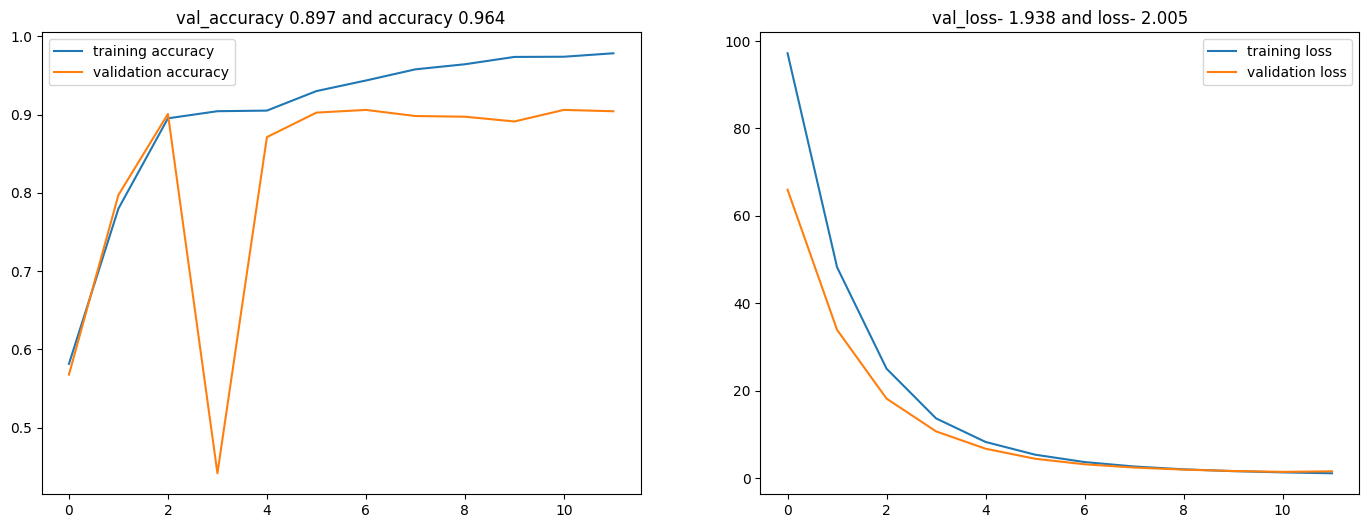

In [42]:
plt.subplots(nrows=1,ncols=2,figsize = (17,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])   
plt.legend(['training accuracy','validation accuracy'])
plt.title(f'val_accuracy {round(history.history["val_accuracy"][8],ndigits=3)} and accuracy {round(history.history["accuracy"][8],ndigits=3)}')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title(f'val_loss- {round(history.history["val_loss"][8],ndigits=3)} and loss- {round(history.history["loss"][8],ndigits=3)}')